# Integration of the biomass composition and fitting of energetic parameters
This notebook utilises the biomass composition calculated in GenerateDynamicComposition as well as cultivation data from the retentostat and chemostats. The energetic parameters of GAME and NGAME are calculated here through identifying the ATP stoichiometry that provides a best fit between the predicted growth rates of the update metabolic model (with certain constraints) and the experimental growth rate, determined from the retentostat regression model

In [1]:
import pandas as pd
import numpy as np
import cobra
import matplotlib
import matplotlib.pyplot as plt


from matplotlib.ticker import AutoMinorLocator
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit, minimize
import seaborn as sns

from CBModellingFuncs import *
import threadpoolctl
import os
import pickle 

# os.makedirs("../results/dataframes/fluxes/maps", exist_ok=True)
# os.makedirs("../results/dataframes/fluxes", exist_ok=True)
# os.makedirs("../results/dataframes/f", exist_ok=True)
os.makedirs("../results/dataframes/fluxes/for_escher", exist_ok=True)


max_processes = 25
threadpoolctl.threadpool_limits(limits=max_processes)

cobra_config = cobra.Configuration()
cobra_config.solver = "cplex"
cobra_config.tolerance = 1e-6

### 1.Import model containing recombinant protein production reactions prodcued in ModelUpdate

In [2]:
pichia, m_warnings = cobra.io.validate_sbml_model("../results/ModelWithProduction.xml")



SBML errors in validation, check error log for details.
COBRA warnings in validation, check error log for details.


### 2. Import data of the fermentations
- Process OUR and CPR data to calculate biomass specific rates, accounting for errors and propagating 
- Introducing assumed error due to a presumed lack of sensitivity

In [3]:
glucose_mw = 180.156

# FermData = pd.read_csv(f"../data/FermDataDynamic.csv")
FermData = pd.read_csv(f"../results/dataframes/cultivation_data/FermDataDynamic.csv")
sample_info = pd.read_csv(f"../data/SampleInfo.csv", index_col=0)
cul_grp_dict = sample_info["Chemostat Length"].to_dict()

FermData["Cultivation Group"] = FermData.Cultivation.apply(lambda x :cul_grp_dict.get(x))
FermData["Time d"] = [str(round(x,1)) if not type(x) == str else x for x in FermData["Time d"].to_list()]
FermData["Time h"] = [str(round(x,1)) if not type(x) == str else x for x in FermData["Time h"].to_list() ]

FermData.loc[FermData["Cultivation Group"] == "C0.1", "Time d"] = "C0.1"


FermData["qS mmol/gh"] = FermData["qS g/gh"]/(glucose_mw/1000)
FermData["qS viable mmol/gh"] = FermData["qS viable g/gh"]/(glucose_mw/1000)
FermData["qS model mmol/gh"] = FermData["qS model g/gh"]/(glucose_mw/1000)
FermData["qP g/gh"] = FermData["qP mg/gh"]/1000
FermData["qP model g/gh"] = FermData["qP model mg/gh"]/1000
# FermData["qp/YPSmax"] = FermData["qP model g/gh"]/max_vhh_glc_yield
# FermData["qs Growth g/gh"] = FermData["qS g/gh"] - FermData["qp/YPSmax"]
# FermData["qs regress Growth g/gh"] = FermData["qS model g/gh"] - FermData["qp/YPSmax"]

chemostats = FermData[~FermData["Cultivation"].isin(["C023", "C024", "C030", "C034", "C035", "C036"])].copy()

FermData = FermData[FermData["Cultivation Group"].notna()]

# Used later one for analysis of individual cultivations
SeparateFermData = FermData.copy()


qco2_err = FermData.groupby("Time d", as_index=False).apply(PropagateError,
                                                       value_col="CPR",
                                                       error_col="CPR_Std",
                                                       biomass_col="Biomass model g/L",
                                                       output_name="qCO2 model").set_index("Time d")

qo2_err = FermData.groupby("Time d", as_index=False).apply(PropagateError,
                                                       value_col="OUR",
                                                       error_col="OUR_Std",
                                                       biomass_col="Biomass model g/L",
                                                       output_name="qO2 model").set_index("Time d")

qco2_verr = FermData.groupby("Time d", as_index=False).apply(PropagateError,
                                                       value_col="CPR",
                                                       error_col="CPR_Std",
                                                       biomass_col="Biomass viable model g/L",
                                                       output_name="qCO2 viable model").set_index("Time d")

qo2_verr = FermData.groupby("Time d", as_index=False).apply(PropagateError,
                                                       value_col="OUR",
                                                       error_col="OUR_Std",
                                                       biomass_col="Biomass viable model g/L",
                                                       output_name="qO2 viable model").set_index("Time d")


FermData = FermData.groupby(["Cultivation Group", "Sample Point", "Time h", "Time d"]).agg(["mean", "std"])


FermData = FermData.droplevel([0,1,2])

FermData = qco2_err.combine_first(FermData)
FermData = qco2_verr.combine_first(FermData)
FermData = qo2_err.combine_first(FermData)
FermData = qo2_verr.combine_first(FermData)

FermData = FermData.sort_values(by=("Average Growth Rate 1/h", "mean"), ascending=False)
FermData = FermData.abs()

sp_gr_dict = FermData[("Growth Rate model 1/h","mean")].to_dict()

OGFermData = FermData.copy()

assume_error(FermData, ['5.9', '7.9', '9.9', '13.9', '16.9','19.9', '23.9', '27.9'], "qCO2 viable model mmol/gh", 50)
assume_error(FermData, FermData.index, "qO2 viable model mmol/gh", 50)

sampling_points = FermData.index

#####  Plot of the biomass specific gas exchange rates and the updated bounds with the assumed additional error

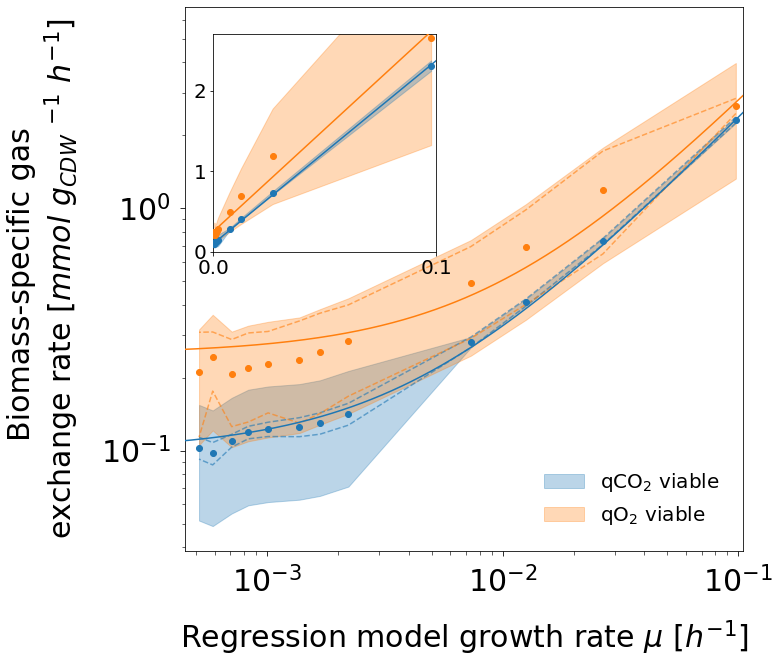

In [4]:
cmap = plt.cm.get_cmap('tab10', 10)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xscale("log")
ax.set_yscale("log")

x = FermData.loc[:,("Growth Rate model 1/h", "mean")].values

y_co2 = OGFermData.loc[:,("qCO2 viable model mmol/gh", "mean")].values
y_co2_sd = OGFermData.loc[:,("qCO2 viable model mmol/gh", "std")].values
y_o2 = OGFermData.loc[:,("qO2 viable model mmol/gh", "mean")].values
y_o2_sd = OGFermData.loc[:,("qO2 viable model mmol/gh", "std")].values

p_co2 = np.polynomial.Polynomial.fit(x,y_co2,1)
ax.scatter(x,y_co2, c=color_list[0],zorder=10)
ax.plot(np.linspace(1e-4,0.2,10000),p_co2(np.linspace(1e-4,0.2,10000)),c=color_list[0],zorder=5)
ax.plot(x, y_co2+y_co2_sd, linestyle="--", alpha=0.6, color=color_list[0])
ax.plot(x, y_co2-y_co2_sd, linestyle="--", alpha=0.6, color=color_list[0])


p_o2 = np.polynomial.Polynomial.fit(x,y_o2,1)
ax.scatter(x,y_o2, c=color_list[1],zorder=10)
ax.plot(np.linspace(1e-4,0.2,10000),p_o2(np.linspace(1e-4,0.2,10000)),c=color_list[1],zorder=5)
ax.plot(x, y_o2+y_o2_sd, linestyle="--", alpha=0.6, color=color_list[1])
ax.plot(x, y_o2-y_o2_sd, linestyle="--", alpha=0.6, color=color_list[1])


y_co2_sd = FermData.loc[:,("qCO2 viable model mmol/gh", "std")].values
ax.fill_between(x, y_co2+y_co2_sd, y_co2-y_co2_sd, alpha=0.3, color=color_list[0], label="qCO$_2$ viable")

y_o2_sd = FermData.loc[:,("qO2 viable model mmol/gh", "std")].values
ax.fill_between(x, y_o2+y_o2_sd, y_o2-y_o2_sd, alpha=0.3, color=color_list[1], label="qO$_2$ viable")



ax.set_xlim(4.5e-4,0.105)

ax.set_xlabel('Regression model growth rate $\mu\ [h^{-1}]$', fontsize=30, labelpad=20)
ax.set_ylabel('Biomass-specific gas \nexchange rate $[mmol\ g_{CDW}\ ^{-1}\ h^{-1}$]', fontsize=30,labelpad=20)
ax.tick_params(labelsize=30, pad=10, length=5)
ax.tick_params(which="minor",length=3.5)

axins = ax.inset_axes([0.05, 0.55, 0.4, 0.4])

axins.scatter(x,y_co2, c=color_list[0],zorder=10)
axins.plot(np.linspace(1e-4,0.2,10000),p_co2(np.linspace(1e-4,0.2,10000)),c=color_list[0],zorder=5)
axins.fill_between(x, y_co2+y_co2_sd, y_co2-y_co2_sd, alpha=0.3, zorder=10, color=color_list[0])

axins.scatter(x,y_o2,  c=color_list[1],zorder=10)
axins.plot(np.linspace(1e-4,0.2,10000),p_o2(np.linspace(1e-4,0.2,10000)),c=color_list[1],zorder=5)
axins.fill_between(x, y_o2+y_o2_sd, y_o2-y_o2_sd, alpha=0.3, zorder=0, color=color_list[1])

axins.set_xlim([0,0.1])
axins.set_ylim([0,2.7])
axins.xaxis.set_major_locator(MultipleLocator(0.1))
axins.yaxis.set_major_locator(MultipleLocator(1))

axins.tick_params(labelsize=20)

ax.legend(loc='lower right',bbox_to_anchor=(0.99,0.01), frameon=False, 
      fontsize='small',prop={'size':20})


fig.savefig(f"../results/plots/Mu_vs_Gas.png",
        bbox_inches='tight',transparent=True)

### 3. Import biomass compositions calculated in GenerateDynamicComposition

The stoichiometry of each biomass equations is imported. The cultivation info is update if glycogen consumption wa sobserved - only for the derived equation

A reaction for each biomass equaiton generateion method and each time point is generated in the metabolic model and used in all later analysis

In [5]:
met_model_dict = pd.read_csv(f"../results/dataframes/biomass/AllMolswFormula.csv", index_col=0)

# DerivedStoich = pd.read_csv("../results/dataframes/ScaledDerivedStoich.csv", index_col=0)
# InterpolatedStoich = pd.read_csv("../results/dataframes/ScaledInterpolatedStoich.csv", index_col=0)
# FittedStoich = pd.read_csv("../results/dataframes/ScaledFittedStoich.csv", index_col=0)
DerivedStoich = pd.read_csv("../results/dataframes/biomass/ScaledDerivedStoich.csv", index_col=0)
InterpolatedStoich = pd.read_csv("../results/dataframes/biomass/ScaledInterpolatedStoich.csv", index_col=0)
FittedStoich = pd.read_csv("../results/dataframes/biomass/ScaledFittedStoich.csv", index_col=0)


DSComp, DRinfo = StoichToComp(DerivedStoich, FermData, met_model_dict)
ISComp, IRinfo = StoichToComp(InterpolatedStoich, FermData, met_model_dict)
FSComp, FRinfo = StoichToComp(FittedStoich, FermData, met_model_dict)

# DRinfo.to_csv(f"../results/dataframes/DerivedRetentInfo.csv")
# IRinfo.to_csv(f"../results/dataframes/InterpolatedRetentInfo.csv")
# FRinfo.to_csv(f"../results/dataframes/FittedRetentInfo.csv")

DRinfo.to_csv(f"../results/dataframes/cultivation_data/DerivedRetentInfo.csv")
IRinfo.to_csv(f"../results/dataframes/cultivation_data/InterpolatedRetentInfo.csv")
FRinfo.to_csv(f"../results/dataframes/cultivation_data/FittedRetentInfo.csv")

updated_pichia = pichia.copy()

add_biomass(updated_pichia, DSComp, met_model_dict, "Derived")
add_biomass(updated_pichia, ISComp, met_model_dict, "Interpolated")
add_biomass(updated_pichia, FSComp, met_model_dict, "Fitted")

In [6]:
model_viab_cols = ["Growth Rate model 1/h", "qS model mmol/gh","qP model g/gh", 
                   "qCO2 viable model mmol/gh", "qO2 viable model mmol/gh", "qStorGlyc mmol/gh"]

viab_cols = ["Average Growth Rate 1/h", "qS viable mmol/gh","qP g/gh", 
             "qCO2 viable mmol/gh", "qO2 viable mmol/gh", "qStorGlyc mmol/gh"]

### 4. Energetic parameter fitting


### 4.i Fitting GAM using an NGAM calculated from the stoichiometric conversion of mS
##### a) Converting mS of retentostat cultivations to NGAM


In [7]:
# df_stats= pd.read_csv("../results/dataframes/StatsDynamicRetentostat.csv", index_col=0)
df_stats= pd.read_csv("../results/dataframes/cultivation_data/StatsDynamicRetentostat.csv", index_col=0)
sc_stats = df_stats[df_stats.index.isin(["C023", "C024", "C030"])]
av_ret_ms = sc_stats["mS opt (mg/g.h)"].mean()/1000
sd_ret_ms = sc_stats["mS opt (mg/g.h)"].std()/1000

av_ATPM = round(float(ATPM_predict(pichia, av_ret_ms)),3)

print(f"Retentosat Results:ms = {av_ret_ms}, ATPM = {av_ATPM}")

updated_pichia.reactions.ATPM.bounds = (av_ATPM, 1000)

Retentosat Results:ms = 0.00364935356803525, ATPM = 0.649


##### 4.i.b) Determination of GAM (growth-associated maintenance energy requirement)

The GAM is determined through fitting the stoichiometry of ATP in the biomass composition such that the euclidean distance between the metaoblic model predicted and experimental growth rates is minimised. A weighting is applied using the SD calculated between the regression fits of the individual retentostat cultivations. 

In [8]:
o2=True
co2=True
ATPstoichdict = {}


bm_generation_methods = ["Consensus", "ScaledConsensus", "Derived", "Interpolated", "Fitted"]
datasets = [DRinfo, DRinfo, DRinfo, IRinfo, FRinfo]
    
model = updated_pichia.copy()

for i, biomass_type in enumerate(bm_generation_methods):

    data = datasets[i].copy()

    params_viab = data.loc[:,model_viab_cols]

    with model as temp_model:  

        for rxn in ["COF", "RNA", "DNA"]: # all biomass reactions use these reactions to produce components of equation
            temp_model.reactions.get_by_id(rxn).bounds = (0,1000)

        # all reactions needed to produce components for each biomass composition are activated within the function

        stoich_viable, stoich_SS = DetermineGAME(temp_model, params_viab, biomass_type=biomass_type, co2=co2, o2=o2, method="eWRSS", combine=False)
        ATPstoichdict[f"{biomass_type}"] = stoich_viable
        print(f"{biomass_type}, SS = {stoich_SS}, Stoich = {stoich_viable}")
    

# ATPstoichdict          

Consensus, SS = 1386.8143503627207, Stoich = 94.0
ScaledConsensus, SS = 82.30809410489016, Stoich = 94.0
Derived, SS = 31.292685413939083, Stoich = 108.0
Interpolated, SS = 41.83105354629802, Stoich = 108.0
Fitted, SS = 50.56131652089843, Stoich = 108.0


##### 4.i.c) Growth rate predictions with optimal GAM

After the "best" GAM value is determined, it is incorporated into the biomass compositions and growth rates are predicted. 

In [9]:
# o2=True
mu_df = pd.DataFrame(columns=DRinfo.index) 

mu_df.loc["Experimental mu",:] = DRinfo[("Growth Rate model 1/h", "mean")] 
mu_df.loc["Experimental mu SD",:] = DRinfo[("Growth Rate model 1/h", "std")] 

bm_generation_methods = ["Consensus", "ScaledConsensus", "Derived", "Interpolated", "Fitted"]
datasets = [DRinfo, DRinfo, DRinfo, IRinfo, FRinfo]


model = updated_pichia.copy()

for i, biomass_type in enumerate(bm_generation_methods):

    data = datasets[i].copy()
   
    params_viab = data.loc[:,model_viab_cols]

    if biomass_type in ["Consensus", "ScaledConsensus"]:
        
        params_viab["qStorGlyc mmol/gh"] = 0


    with model as temp_model:

        for name, values in params_viab.iterrows():
            
            with temp_model:
                set_biomass_objective(temp_model, biomass_type, name)
                
                result = constrain_predict(temp_model, values, slim=True, co2=co2, o2=o2)
                mu_df.loc[f"{biomass_type} - without",name] = result

                atp = ATPstoichdict[f"{biomass_type}"]
                if biomass_type in ["Consensus", "ScaledConsensus"]:
                    additional_atp(temp_model, biomass_type, atp, combine=False)
                else:
                    additional_atp(temp_model, f"{biomass_type}Biomass{name}", atp, combine=False)
                    

                result = constrain_predict(temp_model, values, slim=True, co2=co2, o2=o2)
                mu_df.loc[f"{biomass_type}",name] = result
                          

##### 4.i.d) Plot the predicted vs experimental growth rates
The growth rate predictions for each different method at each different growth rate are dividided by the average of the regression model results. This data is then plotted below, such that a value of 1 represents an identical growth rate as that of the regression model. 

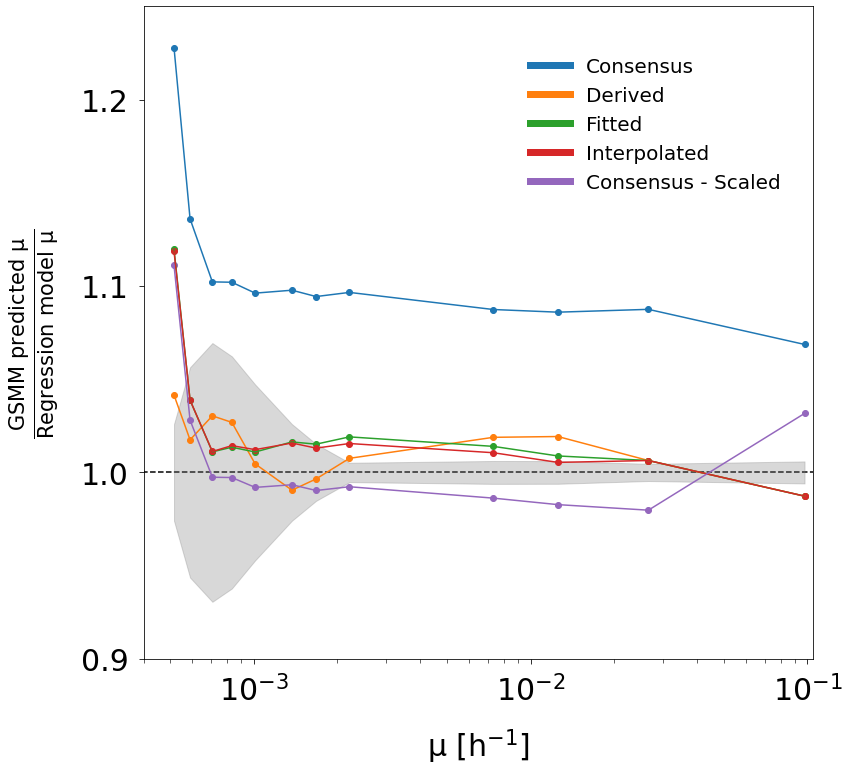

In [10]:

rel_mu_df = mu_df.sort_values(by="Experimental mu", axis=1).astype(float)
exp_y = rel_mu_df.loc["Experimental mu"]
rel_mu_df = rel_mu_df.div(exp_y)

sd = rel_mu_df.loc["Experimental mu SD"]

rel_mu_df = rel_mu_df.iloc[2:,]

co2 = True
        
fig, ax = plt.subplots(1, figsize=(12,12))

params = {'mathtext.default': 'regular'}          
plt.rcParams.update(params)
ax.hlines(1,0,1, color="black", linestyle="--", zorder=0)


row_mask = ["Consensus", 
            "Derived",
            "Fitted",
            "Interpolated", 
            "ScaledConsensus"]

    ########
for i, row in rel_mu_df.loc[row_mask].iterrows():
    ax.scatter(exp_y, row)
    ax.plot(exp_y, row, label=i)
    
ax.fill_between(exp_y, 1-sd, 1+sd, alpha=0.3, zorder=0,color="grey")

 

ax.set_ylabel(r'$\frac{GSMM\ predicted\ \mu}{Regression\ model\ \mu}$', fontsize=30, labelpad=20)
ax.set_xlabel('$\mu\ [h^{-1}]$', fontsize=30,labelpad=20)
ax.tick_params(labelsize=30, pad=10, length=5)
ax.tick_params(which="minor",length=3.5)
ax.set_yticks([0.9, 1, 1.1, 1.2]) 


# add legend
handles, labels = ax.get_legend_handles_labels()
labels = [x if not x == "ScaledConsensus" else "Consensus - Scaled" for x in labels]
legend = ax.legend(handles, labels, loc='upper left',bbox_to_anchor=(0.55,0.95), frameon=False, 
              fontsize=20) 
[h.set_linewidth(7) for h in legend.legendHandles]

ax.set_xscale('log')


ax.set_xlim(0.0004, 0.105)
ax.set_ylim(0.9, 1.25)
fig.savefig(f"../results/plots/MuComparisonRelative_WithCO2_MaxStoich.png",
        bbox_inches='tight',transparent=True)

##### 4.i.d) opt: An alternative representation, where the growth rate itself is plotted on a log scale. A perfect fit to the regression model would fall perfectly on the diagonal. It is harder to distinguish the magnitude of the differences here, hence the relative plot is better

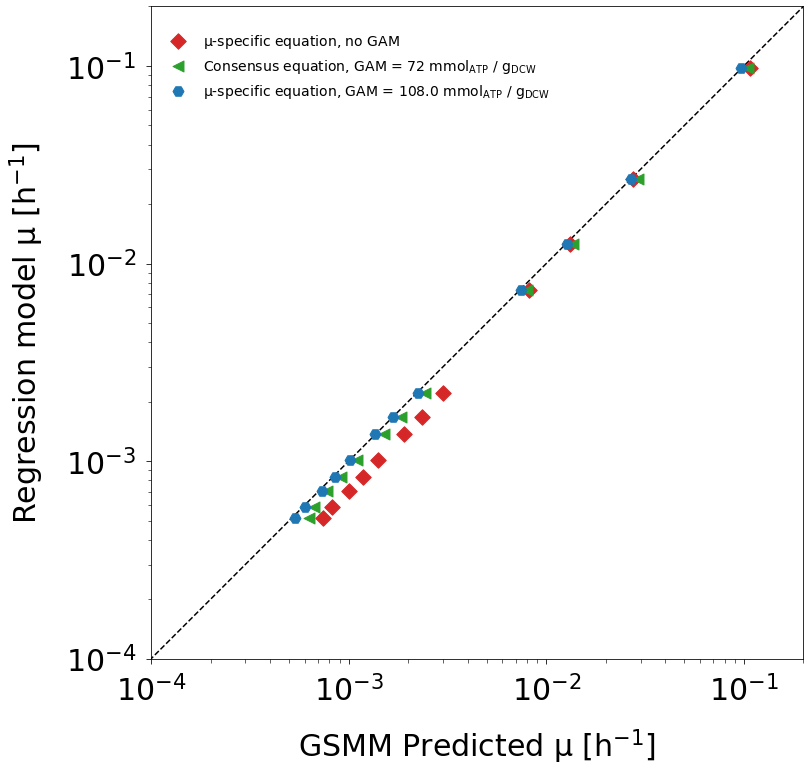

In [11]:
co2 = True
        
fig, ax = plt.subplots(1, figsize=(12,12))

params = {'mathtext.default': 'regular'}          
plt.rcParams.update(params)
ax.plot([0,1],[0,1], c="black", linestyle="--", zorder=0)

exp_y = mu_df.loc["Experimental mu"]


    ########

pred_y = mu_df.loc[f"Derived - without"]

ax.scatter(pred_y, 
           exp_y, 
           marker="D", s=120, c=color_list[3],
           label=f"$\mu$-specific equation, no GAM")

########

pred_y = mu_df.loc[f"Consensus"] 
ax.scatter(pred_y, 
           exp_y, 
           marker="<", s=120, c=color_list[2],
           label="Consensus equation, GAM = 72 $mmol_{{ATP}}\ /\ g_{{DCW}}$")


########

atp = ATPstoichdict[f"Derived"] 
pred_y = mu_df.loc[f"Derived"] 
label = f"$\mu$-specific equation, GAM = {atp} $mmol_{{ATP}}\ /\ g_{{DCW}}$"
ax.scatter(pred_y, 
           exp_y, 
           marker="H", s=120, c=color_list[0],
           label=label)

ax.set_xlabel('GSMM Predicted $\mu\ [h^{-1}]$', fontsize=30, labelpad=20)
ax.set_ylabel('Regression model $\mu\ [h^{-1}]$', fontsize=30,labelpad=20)
ax.tick_params(labelsize=30, pad=10, length=5)
ax.tick_params(which="minor",length=3.5)
ax.set_aspect('equal')


ax.legend(loc='upper left',bbox_to_anchor=(0,0.98), frameon=False, 
      fontsize=14)

ax.set_yscale('log')
ax.set_xscale('log')


ax.set_xlim(10e-5, 0.2)
ax.set_ylim(10e-5, 0.2)

fig.savefig(f"../results/plots/MuComparisonLog_WithCO2_MaxStoich.png",
        bbox_inches='tight',transparent=True)
        

### 4.ii Fitting GAM using an NGAM determined from a linear fit of the maximal qATP across all growth rates
##### 4.ii.a) Prediction qATP across all growth rates for each biomass equation generation method


In [12]:
qATP_df = pd.DataFrame()
gr_df = pd.DataFrame()
o2=True
co2=True


bm_generation_methods = ["Consensus", "ScaledConsensus", "Derived", "Interpolated", "Fitted"]
datasets = [DRinfo, DRinfo, DRinfo, IRinfo, FRinfo]


model = updated_pichia.copy()

for i, equation_name in enumerate(bm_generation_methods):

    data = datasets[i].copy()

    params_viab = data.loc[:,model_viab_cols].abs()

    for j, name in enumerate(sampling_points):
        with model as temp_model:
            set_objective(temp_model, "ATPM")
            exchanges = "adjusted"
            values = params_viab.loc[name]
            
            mu, mu_sd = values[:2]
            with temp_model:

                if equation_name in ["Consensus", "ScaledConsensus"]:
                    temp_model.reactions.get_by_id(equation_name).add_metabolites({"atp_c":0, "h2o_c":0,
                                                                                   "adp_c":0, "pi_c":0,  "h_c":0}, 
                                                                                  combine=False)
                    for rxn in ['STEROLS', 
                                'CARBOHYDRATES',
                                'LIPIDS',           
                                'PROTEINS',         
                                "PHOSPHOLIPIDS",
                                "RNA", "DNA", "COF"]:
                        temp_model.reactions.get_by_id(rxn).bounds = (0,1000)

                    temp_model.reactions.get_by_id(equation_name).bounds = (mu, 1000) 


                else:
                    temp_model.reactions.get_by_id(f"{equation_name}Biomass{name}").add_metabolites({"atp_c":0, "h2o_c":0,
                                                                                               "adp_c":0, "pi_c":0,  "h_c":0}, 
                                                                                              combine=False)
                    for rxn in ["COF", "RNA", "DNA", 
                                f'{equation_name}Protein{name}',f'{equation_name}Carbohydrate{name}',
                                f'{equation_name}Lipid{name}']:
                        temp_model.reactions.get_by_id(rxn).bounds = (0,1000)

                    temp_model.reactions.get_by_id(f"{equation_name}Biomass{name}").bounds = (mu, 1000) #mu+mu_sd)


                result = constrain_predict(temp_model, values, co2=co2, o2=o2)
                qATP_df.at[f"{equation_name}",j] = result["ATPM"]
                gr_df.at[f"{equation_name}",j] = result["growth"]            

columns = DRinfo.loc[:,("Growth Rate model 1/h", "mean")].reset_index()
columns = columns.droplevel(1,axis=1)
columns = pd.MultiIndex.from_frame(columns)

qATP_df.columns = columns
gr_df.columns = columns
qATP_df.to_csv("../results/dataframes/qATP_Predictions.csv")

##### 4.ii.b) Determination of NGAM from a weighted linear fit to the qATP predictions

In [13]:
def linear(x, a,b):
    return a*x + b

def weighted_linear(p, x, y):
    y_hat = linear(x, *p)
    result = y - y_hat
    result = np.sum((result/y_hat)**2)
    return result


In [14]:
row_mask =  qATP_df.index
NGAMdict = {}
NGAMseries = pd.Series(index=row_mask,dtype=float)
for i, row in enumerate(row_mask):
    x = gr_df.loc[row,:].copy() 
    y = qATP_df.loc[row,:].copy() 
   
    
    x = x[~(y > 100)]
    y = y[~(y > 100)]
    x = x[~(y <= 0)]
    y = y[~(y <= 0)]
    
    if (x.empty) or (len(x)<3):
        continue
    res = minimize(fun=weighted_linear, x0=[70,0.5], 
                   args=(x.values, y.values))
    
    opt = res.x
    
    matp = opt[1]
    matp = round(matp,2)
    NGAMseries[row] = matp 
    
    print(f"{row} NGAM = {matp}")
    
NGAMseries.to_csv('../results/dataframes/NGAMseries.csv')
GAM_df = qATP_df.subtract(NGAMseries,axis=0)/gr_df 

Consensus NGAM = 0.69
ScaledConsensus NGAM = 0.66
Derived NGAM = 0.65
Interpolated NGAM = 0.66
Fitted NGAM = 0.66


##### 4.ii.c) Determination of GAM (growth-associated maintenance energy requirement)

The optimal GAM of each biomass equation generation method is determined, using the optimal NGAM determined above. 

The GAM is determined through fitting the stoichiometry of ATP in the biomass composition such that the euclidean distance between the metaoblic model predicted and experimental growth rates is minimised. A weighting is applied using the SD calculated between the regression fits of the individual retentostat cultivations. 

In [15]:
o2=True
co2=True
ATPstoichdict = {}


bm_generation_methods = ["Consensus", "ScaledConsensus", "Derived", "Interpolated", "Fitted"]
datasets = [DRinfo, DRinfo, DRinfo, IRinfo, FRinfo]


model = updated_pichia.copy()

for i, biomass_type in enumerate(bm_generation_methods):

    data = datasets[i].copy()

    params_viab = data.loc[:,model_viab_cols]

    with model as temp_model:  

        for rxn in ["COF", "RNA", "DNA"]: # all biomass reactions use these reactions to produce components of equation
            temp_model.reactions.get_by_id(rxn).bounds = (0,1000)

        
        # Viability adjusted
        atpm = NGAMseries[f"{biomass_type}"]
        if np.isnan(atpm):
            print(f"FAILED: {biomass_type}")
        else:
            temp_model.reactions.ATPM.bounds = (atpm,1000)
            stoich_viable, stoich_SS = DetermineGAME(temp_model, params_viab, biomass_type=biomass_type, co2=co2, o2=o2, method="eWRSS", combine=False)
            ATPstoichdict[f"{biomass_type}"] = stoich_viable
            print(f"{biomass_type}, SS = {stoich_SS}, Stoich = {stoich_viable}")
                    

Consensus, SS = 924.264724646622, Stoich = 92.0
ScaledConsensus, SS = 89.19131841177122, Stoich = 92.0
Derived, SS = 29.30181094979842, Stoich = 108.0
Interpolated, SS = 13.243322347704716, Stoich = 108.0
Fitted, SS = 16.11766311759014, Stoich = 108.0


##### 4.ii.d) Plotting of the determined energetic parameters

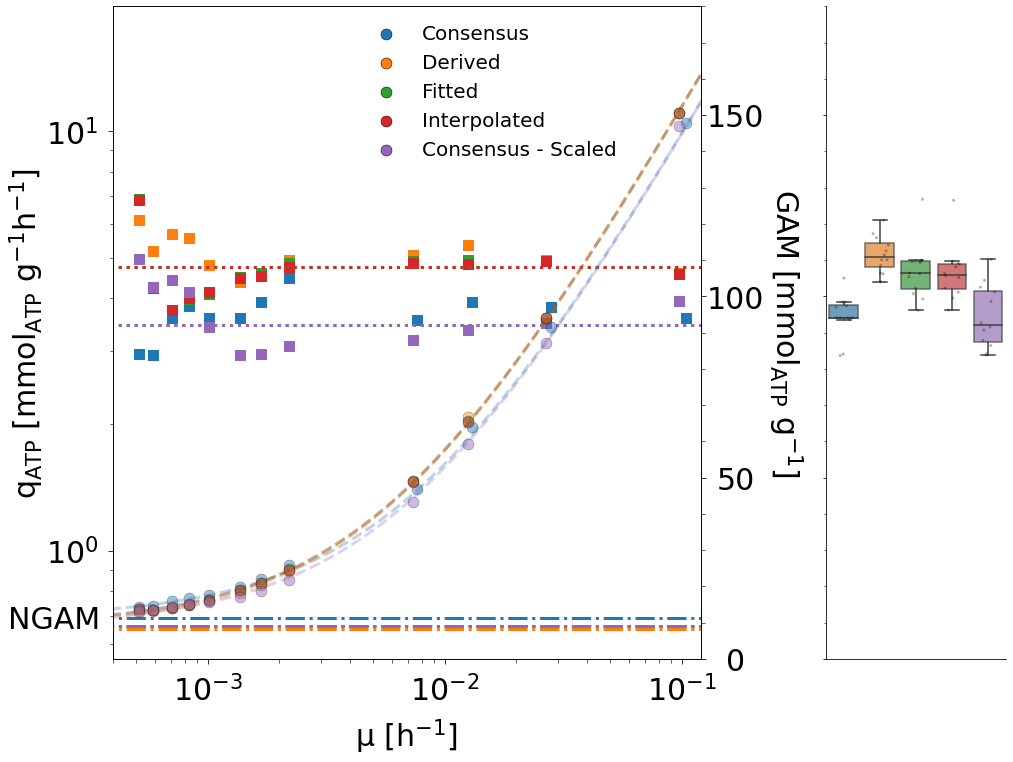

In [16]:
fig = plt.figure(figsize=(16, 12)) #, dpi= 80)
grid = plt.GridSpec(nrows=5, ncols=9, hspace=0.5, wspace=0.3)

# # Define the axes
ax_main = fig.add_subplot(grid[:, :-3])
ax2_main = ax_main.twinx()
ax_main.set_xscale('log')
ax_main.set_yscale('log')

ax_right = fig.add_subplot(grid[:, -2:], xticklabels=[], yticklabels=[])
ax2_main.get_shared_y_axes().join(ax2_main, ax_right)

ax_main.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax_main.patch.set_visible(False) 

row_mask = ["Consensus", 
            "Derived",
            "Fitted",
            "Interpolated",
            "ScaledConsensus"]
            

cmap = plt.cm.get_cmap('tab10', 10)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
       
x_plot = np.linspace(0,0.15,1000)

# Plot main ax

all_gam_lims = []
all_gam = []

for i, row in enumerate(row_mask):
    
    # Calculate median qATP for each time point, using a cutoff of at least 80% of the maximum qATP
    gr_range = gr_df.loc[row,:].copy()
    qatp_range = qATP_df.loc[row,:]
    gam_range = GAM_df.loc[row, :].copy()
    
    mask = ~((qatp_range > 100)^(qatp_range <= 0))
    gr_range = gr_range[mask]
    qatp_range = qatp_range[mask]
    gam_range = gam_range[mask]
    
    cutoff = (qatp_range.groupby("Time d").max()*0.9).repeat(qatp_range.groupby("Time d").count())
    mask = qatp_range.loc[cutoff.index,:] > cutoff.values
    gr_range = gr_range[mask]
    qatp_range = qatp_range[mask]
    gam_range = gam_range[mask]
    
    gr_range.sort_index(level="Growth Rate model 1/h",ascending=False, inplace=True)
    qatp_range.sort_index(level="Growth Rate model 1/h",ascending=False, inplace=True)
    gam_range.sort_index(level="Growth Rate model 1/h",ascending=False, inplace=True)
    
    # Plot qATP values
    ax_main.scatter(gr_range, qatp_range, c=color_list[i], label=row, s=120, marker="o", edgecolors="black", alpha=0.45, linewidths=0.5) 
    ax2_main.scatter(gr_range, gam_range,color=color_list[i],marker="s",alpha=1,s=120)
#     # Next calcualte the range of GAM
    all_gam.append(gam_range)
    
    ngam = NGAMseries[row]
    gam = ATPstoichdict[row]
    
    # Plot linear fit using error weighted GAM prediction and NGAM 
    ax_main.plot(x_plot, x_plot*gam + ngam, c=color_list[i], linestyle="--", lw=3,alpha=0.3,zorder=0)
    
    # Plot horizontal GAM lines
    ax2_main.hlines(gam, 0,1, colors=color_list[i],linestyles=':', lw=3)
    ax_main.hlines(ngam, 0,1, colors=color_list[i],linestyles='-.', lw=3)
    
GAM_data = pd.concat(all_gam,axis=1)

sns.boxplot(data=GAM_data,
            ax=ax_right, orient="v", palette="tab10",
            showfliers=False, boxprops=dict(alpha=.7), 
            order=row_mask) 

sns.stripplot(data=GAM_data,
             ax=ax_right, size=3, color="black", linewidth=0,alpha=0.3,
             order=row_mask,jitter=0.25)



# add matp label 
ax_main.text(-0.1, 0.06, 'NGAM',#'$m_{ATP}$', 
        horizontalalignment='center',
        verticalalignment='center', 
        fontsize=30,
        transform=ax_main.transAxes)

# add legend
handles, labels = ax_main.get_legend_handles_labels()
labels = [x if not x == "ScaledConsensus" else "Consensus - Scaled" for x in labels]
legend = ax_main.legend(handles, labels, loc='upper left',bbox_to_anchor=(0.4,1), frameon=False, 
              fontsize=20) #,prop={'size':20})
[h.set_alpha(1) for h in legend.legendHandles]

# define axes limits
ax_main.set_xlim(0.0004,0.12)
ax2_main.set_ylim(0,180)

# set axes labels
ax_main.set_xlabel('$\mu\ [h^{-1}]$', fontsize=30, labelpad=10)
ax_main.set_ylabel('$q_{ATP}$ $[mmol_{ATP}\ g^{-1} h^{-1}]$', fontsize=30,labelpad=0)
ax2_main.set_ylabel('GAM $[mmol_{ATP}\ g^{-1}]$', fontsize=30,labelpad=40, rotation=270)

# set axes ticks params
ax_main.tick_params(labelsize=30, pad=10, length=5)
ax_main.tick_params(which="minor",length=3.5)
ax2_main.tick_params(labelsize=30, pad=10, length=5, axis="x")
ax2_main.tick_params(labelsize=30, pad=30, length=5, axis="y")
ax2_main.tick_params(which="minor",length=3.5)

ax2_main.yaxis.set_major_locator(plt.MaxNLocator(4))
ax_right.yaxis.set_major_locator(plt.MaxNLocator(4))

ax2_main.yaxis.set_minor_locator(AutoMinorLocator())
ax_right.yaxis.set_minor_locator(AutoMinorLocator())

ax_right.set_xticks([])

for label in ax2_main.get_yticklabels():
    label.set_ha("center")
    
# hide spines of right xes
ax_right.spines[['right', 'top']].set_visible(False)


  
fig.savefig(f"../results/plots/Mu_vs_qATP_GAM.png",
        bbox_inches='tight',transparent=True)

##### 4.ii.e) Growth rate predictions with optimal energetic parameters

After the "best" GAM value is determined, it is incorporated into the biomass compositions and growth rates are predicted. 

In [17]:
mu_df = pd.DataFrame(columns=DRinfo.index) 

mu_df.loc["Experimental mu",:] = DRinfo[("Growth Rate model 1/h", "mean")] 
mu_df.loc["Experimental mu SD",:] = DRinfo[("Growth Rate model 1/h", "std")]


bm_generation_methods = ["Consensus", "ScaledConsensus", "Derived", "Interpolated", "Fitted"]
datasets = [DRinfo, DRinfo, DRinfo, IRinfo, FRinfo]


model = updated_pichia.copy()

for i, biomass_type in enumerate(bm_generation_methods):

    data = datasets[i].copy()

    params_viab = data.loc[:,model_viab_cols].abs()

    if biomass_type in ["Consensus", "ScaledConsensus"]:
        
        params_viab["qStorGlyc mmol/gh"] = 0


    with model as temp_model:

        for name, values in params_viab.iterrows():
            
            with temp_model:
                set_biomass_objective(temp_model, biomass_type, name)
                
                # set ATPM and predict growth and save to df
                atpm = NGAMseries[f"{biomass_type}"]
                if np.isnan(atpm):
                    continue
                temp_model.reactions.ATPM.bounds = (atpm,1000)
                with temp_model:
                    if biomass_type in ["Consensus", "ScaledConsensus"]:
                        additional_atp(temp_model, biomass_type, 0, combine=False)
                    else:
                        additional_atp(temp_model, f"{biomass_type}Biomass{name}", 0, combine=False)

                    result = constrain_predict(temp_model, values, slim=True, co2=co2, o2=o2)
                    mu_df.loc[f"{biomass_type} - without",name] = result
                
                # add optimal ATP stoich to biomass rxns                     
                with temp_model:
                    atp = ATPstoichdict[f"{biomass_type}"]
                    if biomass_type in ["Consensus", "ScaledConsensus"]:
                        additional_atp(temp_model, biomass_type, atp, combine=False)
                    else:
                        additional_atp(temp_model, f"{biomass_type}Biomass{name}", atp, combine=False)

                    # predict growth and save to df
                    result = constrain_predict(temp_model, values, slim=True, co2=co2, o2=o2)
                    mu_df.loc[f"{biomass_type}",name] = result
                          
mu_df = mu_df.astype(float)

##### 4.ii.f) Plot the predicted vs experimental growth rates
The growth rate predictions for each different method at each different growth rate are dividided by the average of the regression model results. This data is then plotted below, such that a value of 1 represents an identical growth rate as that of the regression model. 

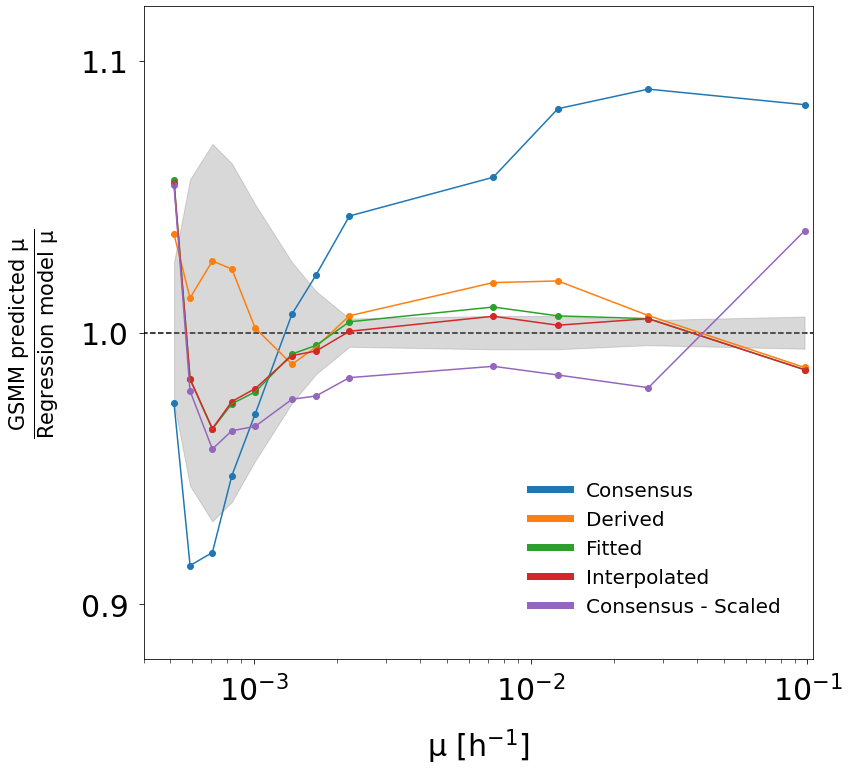

In [18]:

rel_mu_df = mu_df.sort_values(by="Experimental mu", axis=1).astype(float)
exp_y = rel_mu_df.loc["Experimental mu"]
rel_mu_df = rel_mu_df.div(exp_y)

sd = rel_mu_df.loc["Experimental mu SD"]

rel_mu_df = rel_mu_df.iloc[2:,]

co2 = True
        
fig, ax = plt.subplots(1, figsize=(12,12))

params = {'mathtext.default': 'regular'}          
plt.rcParams.update(params)
ax.hlines(1,0,1, color="black", linestyle="--", zorder=0)


row_mask = ["Consensus", 
            "Derived",
            "Fitted",
            "Interpolated",
            "ScaledConsensus"]

for i, row in rel_mu_df.loc[row_mask].iterrows():
    
    ax.scatter(exp_y, row)
    ax.plot(exp_y, row, label=i)
    
ax.fill_between(exp_y, 1-sd, 1+sd, alpha=0.3, zorder=0,color="grey")

ax.set_ylabel(r'$\frac{GSMM\ predicted\ \mu}{Regression\ model\ \mu}$', fontsize=30, labelpad=20)
ax.set_xlabel('$\mu\ [h^{-1}]$', fontsize=30,labelpad=20)
ax.tick_params(labelsize=30, pad=10, length=5)
ax.tick_params(which="minor",length=3.5)

ax.set_yticks([0.9, 1, 1.1]) 

# add legend
handles, labels = ax.get_legend_handles_labels()
# labels = [x.split(" -")[0].split("Scaled")[-1] if not x.split(" -")[0] == "ScaledConsensus" else "Consensus - Scaled" for x in labels]
labels = [x if not x == "ScaledConsensus" else "Consensus - Scaled" for x in labels]
legend = ax.legend(handles, labels, loc='upper left',bbox_to_anchor=(0.55,0.3), frameon=False, 
              fontsize=20)

[h.set_linewidth(7) for h in legend.legendHandles]

ax.set_xscale('log')


ax.set_xlim(0.0004, 0.105)
ax.set_ylim(0.88, 1.12)
fig.savefig(f"../results/plots/MuComparisonRelative_WithCO2_AdjustedATPM.png",
        bbox_inches='tight',transparent=True)


##### 4.ii.f) alternative representation, where the growth rate itself is plotted on a log scale. A perfect fit to the regression model would fall perfectly on the diagonal. It is harder to distinguish the magnitude of the differences here, hence the relative plot is better

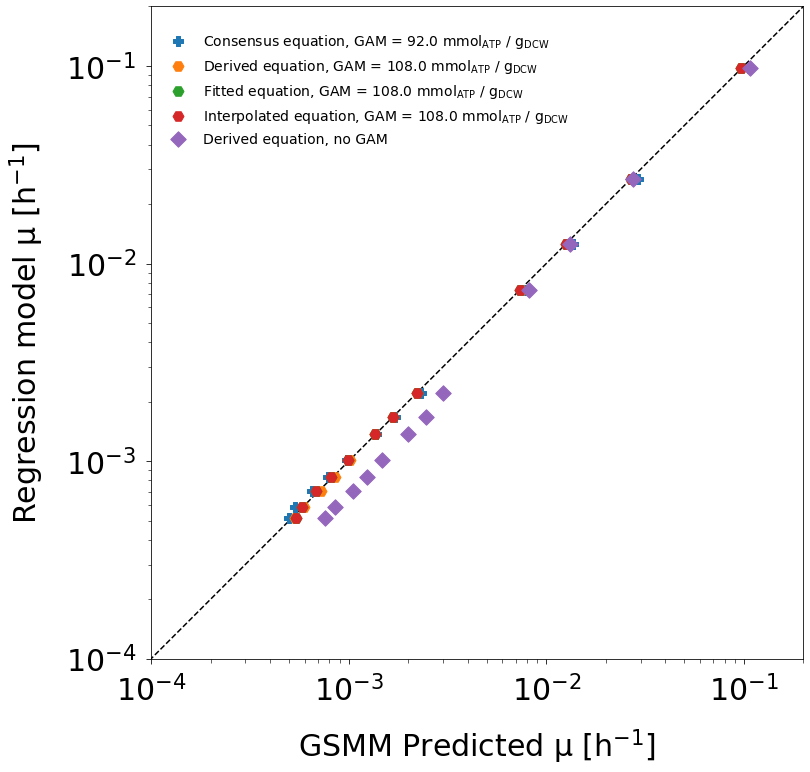

In [19]:
co2 = True

fig, ax = plt.subplots(1, figsize=(12,12))

params = {'mathtext.default': 'regular'}          
plt.rcParams.update(params)
ax.plot([0,1],[0,1], c="black", linestyle="--", zorder=0)

exp_y = mu_df.loc["Experimental mu"]
exp_sd = mu_df.loc["Experimental mu SD"]

    ########
    
atp = ATPstoichdict[f"Consensus"]
pred_y = mu_df.loc[f"Consensus"]
ax.scatter(pred_y, 
           exp_y, 
           marker="P", s=120,c=color_list[0],
           label=f"Consensus equation, GAM = {atp} $mmol_{{ATP}}\ /\ g_{{DCW}}$")

########

atp = ATPstoichdict[f"Derived"]
pred_y = mu_df.loc[f"Derived"]
label = f"Derived equation, GAM = {atp} $mmol_{{ATP}}\ /\ g_{{DCW}}$"
ax.scatter(pred_y, 
           exp_y, 
           marker="H", s=120, c=color_list[1],
           label=label)

##########

atp = ATPstoichdict[f"Fitted"] 
pred_y = mu_df.loc[f"Fitted"]
label = f"Fitted equation, GAM = {atp} $mmol_{{ATP}}\ /\ g_{{DCW}}$"
ax.scatter(pred_y, 
           exp_y, 
           marker="H", s=120, c=color_list[2],
           label=label)

##########

atp = ATPstoichdict[f"Interpolated"] 
pred_y = mu_df.loc[f"Interpolated"]
label = f"Interpolated equation, GAM = {atp} $mmol_{{ATP}}\ /\ g_{{DCW}}$"
ax.scatter(pred_y, 
           exp_y, 
           marker="H", s=120, c=color_list[3],
           label=label)

##########

pred_y = mu_df.loc["Derived - without"] #[f"Scaled - without - WithCO2"]
ax.scatter(pred_y, 
           exp_y, 
           marker="D", s=120, c=color_list[4],
           label=f"Derived equation, no GAM")


ax.set_xlabel('GSMM Predicted $\mu\ [h^{-1}]$', fontsize=30, labelpad=20)
ax.set_ylabel('Regression model $\mu\ [h^{-1}]$', fontsize=30,labelpad=20)
ax.tick_params(labelsize=30, pad=10, length=5)
ax.tick_params(which="minor",length=3.5)
ax.set_aspect('equal')#, adjustable='box')


ax.legend(loc='upper left',bbox_to_anchor=(0,0.98), frameon=False, 
      fontsize=14)

ax.set_yscale('log')
ax.set_xscale('log')


ax.set_xlim(10e-5, 0.2)
ax.set_ylim(10e-5, 0.2)

fig.savefig(f"../results/plots/MuComparisonLog_WithCO2_AdjustedATPM.png",
        bbox_inches='tight',transparent=True)


### 5. Flux distribution predictions and model export
##### i) Exporting the updated metabolic model with the best predictive ATP stoich


In [20]:
model_export = updated_pichia.copy()

sampling_points = DRinfo.index.to_list()
model_export.reactions.ATPM.bounds = (0, 1000)

for sample_point in sampling_points:

    for equation_name in ["Derived","Interpolated", "Fitted"]:
        atp = ATPstoichdict[f"{equation_name}"]
        additional_atp(model_export, f"{equation_name}Biomass{sample_point}", atp, combine=False)
    
for equation_name in ["Consensus", "ScaledConsensus"]:
    atp = ATPstoichdict[f"{equation_name}"]
    additional_atp(model_export, equation_name, atp, combine=False)

    
    
model_export.name = "K. phaffi model iMT1026 Near - zero"
model_export.id = "iMT1026_NZ"
cobra.io.write_sbml_model(model_export, "../results/iMT1026-NZ.xml")
cobra.io.save_json_model(model_export, "../results/iMT1026-NZ.json")

##### ii) Generate parsimonious flux distributions at multiple comparison points

Multiple comparisons:
- Comparisons between different growth rates but with equations generated with the same method
- Comparisons between the same growth rates but with different equation generation methods

In [21]:
co2 = True
equation_names = ["Consensus", "ScaledConsensus", "Derived", "Interpolated", "Fitted"]
all_pfba = pd.DataFrame(columns=pd.MultiIndex.from_product([equation_names,sampling_points]))
    
datasets = [DRinfo, DRinfo, DRinfo, IRinfo, FRinfo]

for i, equation in enumerate(equation_names):
    data = datasets[i].loc[:,model_viab_cols].copy()
    if equation in ["Consensus", "ScaledConsensus"]:
        data["qStorGlyc mmol/gh"] = 0
    
    for name, values in data.iterrows():
        with model_export as temp_model:
            set_biomass_objective(temp_model, equation, name)
            temp_model.reactions.ATPM.bounds = (NGAMseries[f"{equation}"], 1000)

            result = constrain_predict(temp_model, values, parsimonious=True,co2=co2, o2=o2, fopt=0.99)

            result = result.fluxes

            result.name = (equation, name)
            all_pfba.at[:,(equation, name)] = result

# all_pfba.to_csv(f"../results/dataframes/AllpFBA_results.csv")
all_pfba.to_csv(f"../results/dataframes/fluxes/AllpFBA_results.csv")

In [22]:
dyn_car = ["C0.1","0.0","5.9","16.9", "27.9"]

for name in dyn_car:

    df = all_pfba.loc[:,[("Derived", name), ("Consensus", name)]].copy()
    # df.to_csv(f"../results/fluxes/{name}DerCon_Absolute.csv") 
    df.to_csv(f"../results/dataframes/fluxes/for_escher/{name}DerCon_Absolute.csv") 
    df = df/df.loc["Ex_glc_D"].abs()
    # df.to_csv(f"../results/fluxes/{name}DerCon_GlucoseNormalized.csv") 
    df.to_csv(f"../results/dataframes/fluxes/for_escher/{name}DerCon_GlucoseNormalized.csv") 
    

###################################################

comparisons = [("C0.1","0.0"), ("C0.1","5.9"), ("C0.1","9.9"), ("C0.1","16.9"), ("C0.1","27.9"),
               ("0.0","5.9"), ("0.0","9.9"), ("0.0","16.9"), ("0.0","27.9")]

for comp in comparisons:

    first, second = comp
    df = all_pfba.loc[:,[("Derived", first), ("Derived", second)]].copy()
    df = df/df.loc["Ex_glc_D"].abs()
    
    # df.to_csv(f"../results/fluxes/Derived{first}vs{second}_GlucoseNormalized.csv")
    df.to_csv(f"../results/dataframes/fluxes/for_escher/Derived{first}vs{second}_GlucoseNormalized.csv")
    

Additional plot - VHH flux vs growth rate

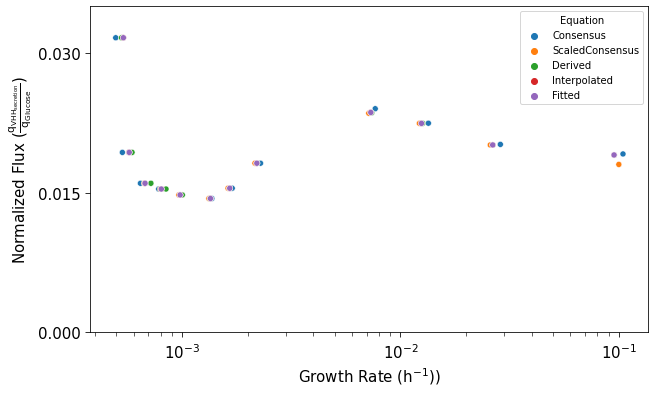

In [23]:
data=pd.concat([all_pfba.loc["growth"],
                                (pichia.metabolites.vHHV_c.formula_weight/1000 *all_pfba.div(all_pfba.loc["Ex_glc_D"]).loc["Ex_vHHV"]).abs()],axis=1)
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=data.reset_index().rename(columns={"level_0":"Equation"}),hue="Equation", x= "growth", y="Ex_vHHV",ax=ax)
ax.set_xlabel( r'Growth Rate ($h^{-1})$)', fontsize=15)
ax.set_ylabel(r'Normalized Flux ($\frac{q_{VHH_{secretion}}}{q_{Glucose}}$)', fontsize=15)
ax.tick_params(labelsize=15, pad=5, length=5)

import matplotlib.ticker as ticker

ax.set_ylim(0, 0.035)
ax.tick_params(which="minor",length=3.5)

ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
ax.set_xscale("log")
fig.savefig(f"../results/plots/qVHH_growth.png",
        bbox_inches='tight',transparent=True,dpi=300)
  